# Creating a Kaggle Workflow

In this project we will run through all of the basic steps from start to finish that you will generally go through when attempting a Kaggle competition.

We'll be working with the most popular Kaggle competition that is geared towards beginners called [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic). In this competition, we'll be predicting which passengers survived the sinking of the Titanic.


## Importing the Data and Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

## Initial Exploration of the Data

One of the most important parts of any data science problem is really understanding your data, and acquiring domain knowledge on the topic you are working with. In this case, understanding the variables that affected the outcome of survival on the Titanic is very important. For example, women and children were given preference to lifeboats, and the class of the passenger likely influenced the outcome as well.

We'll take some time to read the data dictionary provided to us by Kaggle, and we'll explore the data set provided to get a better understanding of our data.

In [2]:
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


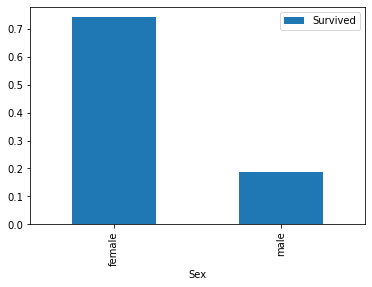

In [3]:
sex_pivot = train.pivot_table(index='Sex', values='Survived')
sex_pivot.plot.bar()
plt.show()

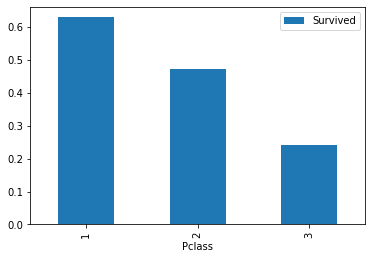

In [4]:
class_pivot = train.pivot_table(index='Pclass', values='Survived')
class_pivot.plot.bar()
plt.show()

Just by looking into the data a bit, we can already see that women and 1st class passengers were more likely to get on the lifeboats and survive.

## Pre-Processing the Data

Here we're going to load in some functions that we created earlier.

In [5]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [6]:
# Function using the above functions to process the dataframe

def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    for col in ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']:
        df = create_dummies(df, col)
        
    return df

train = pre_process(train)
holdout = pre_process(holdout)

## Further Data Exploration

A good Kaggle workflow build combines

* **Data Exploration** to find patterns in the data.
* **Feature Engineering** to create more features out of the patterns we find or through experimentation.
* **Feature Selection** so we have the best subset of our available features.
* **Model Selection** and **Model Tuning**, where we train different types of models and with different hyperparameters until we find the best performing model.

We repeat this cycle in our work to optimize our predictions, make predictions on our holdout set, and then submit those predicitons to Kaggle to get a score.

Next, we're going to continue our data exploration and examine the `SibSp` and `Parch` columns that contain information about the family members of each passenger.

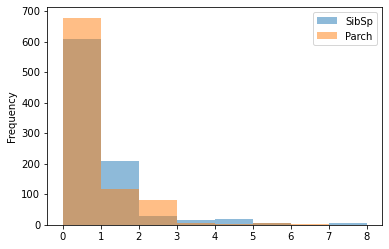

In [7]:
explore_cols = ['SibSp', 'Parch', 'Survived']
explore = train[explore_cols].copy()

explore.drop('Survived',axis=1).plot.hist(alpha=0.5,bins=8)
plt.show()

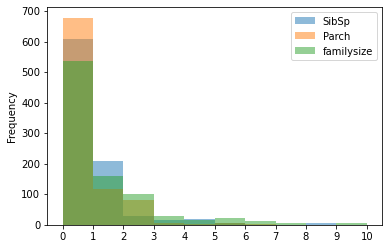

In [8]:
explore['familysize'] = explore[['SibSp', 'Parch']].sum(axis=1)
explore.drop('Survived', axis=1).plot.hist(alpha=0.5, bins=10)
plt.xticks(range(11))
plt.show()

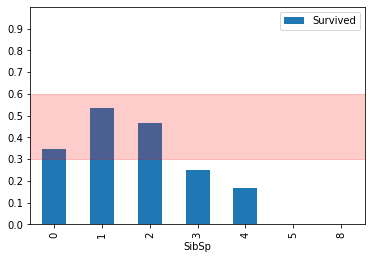

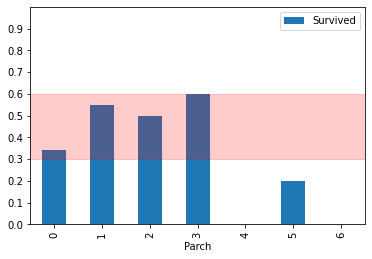

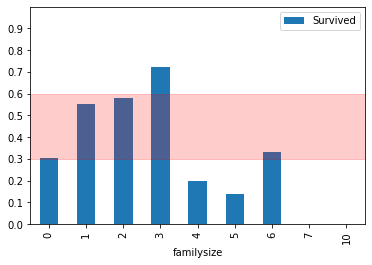

In [9]:
for col in explore.columns.drop('Survived'):
    pivot = explore.pivot_table(index=col, values='Survived')
    pivot.plot.bar(ylim=(0,1), yticks=np.arange(0, 1, .1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    plt.show()

In the `SibSp` column we can see the number of siblings and/or spouses each passenger had onboard. In the `Parch` column, we see the number of parents or children each passenger had onboard. If we add these two columns together we can explore the number of family members each passenger had onboard.

It looks like those with 1 or more family members onboard had higher rates of survival.


## Engineering New Features

We can add the `familysize` as a new feature to our dataset. We'll add a binary column named `isalone` containing the value 1 if the passenger has no family members onboard, and the value 0 if the passenger has one or more family members onboard. 

In [10]:
def gen_isalone(df):
    df['familysize'] = df[['SibSp', 'Parch']].sum(axis=1)
    df['isalone'] = 0
    df.loc[(df['familysize'] == 0), 'isalone'] = 1
    df = df.drop('familysize', axis=1)
    return df

train = gen_isalone(train)
holdout = gen_isalone(holdout)

## Selecting the Best-Performing Features

We're going to write a function that uses scikit-learn's recursive feature elimination class `feature_selection.RFECV` and the random forests algorithm to automate finding the best-performing set of features.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1) # Removes non-numeric columns & columns containing null values
    all_X = df.drop(['Survived', 'PassengerId'], axis=1)
    all_y = df['Survived']
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print('Best Columns: '+'{}'.format(best_columns))
    
    return best_columns

best_cols = select_features(train)

Best Columns: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']


## Finding the Best-Performing Algorithm

We're going to write another function that will use scikit-learn's `model_selection.GridSearchCV` class to find the best performing set of parameters and show us the results so we can see which models were most accurate. Our function will contain a list of models and their hyperparameters to test.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def select_model(df, features):
    
    all_X = df[features]
    all_y = df['Survived']
    
    models = [
        {
            'name': 'LogisticRegression',
            'estimator': LogisticRegression(),
            'hyperparameters':
            {
                'solver': ['newton-cg', 'liblinear']
            }
        },
        {
            'name': 'KNeighborsClassifier',
            'estimator': KNeighborsClassifier(),
            'hyperparameters':
            {
                'n_neighbors': range(1,20,2),
                'weights': ['distance', 'uniform'],
                'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                'p': [1,2]
            }
        },
        {
            'name': 'RandomForestClassifier',
            'estimator': RandomForestClassifier(random_state=1),
            'hyperparameters':
            {
                'n_estimators': [4, 6, 9],
                'criterion': ['entropy', 'gini'],
                'max_depth': [2, 5, 10],
                'max_features': ['log2', 'sqrt'],
                'min_samples_leaf': [1, 5, 8],
                'min_samples_split': [2, 3, 5]
            }
        }
    ]
    
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))
        
        grid = GridSearchCV(model['estimator'],
                           param_grid = model['hyperparameters'],
                           cv = 10)
        grid.fit(all_X, all_y)
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_model'] = grid.best_estimator_
        
        print('Best Score: {}'.format(model['best_score']))
        print('Best Parameters: {}'.format(model['best_params']))
        
    return models

In [17]:
result = select_model(train, best_cols)

LogisticRegression
------------------
Best Score: 0.8204619225967541
Best Parameters: {'solver': 'newton-cg'}
KNeighborsClassifier
--------------------
Best Score: 0.7767041198501874
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
RandomForestClassifier
----------------------
Best Score: 0.8395505617977527
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 6}


## Making a Submission to Kaggle

The last part of our project is to submit our results to Kaggle. We'll write a function to help us automate submitting multiple predictions to Kaggle.

In [18]:
def save_submission_file(model, best_cols, filename='submission.csv'):
    holdout_data = holdout[best_cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout['PassengerId']
    submission_df = {'PassengerId': holdout_ids,
                    'Survived': predictions}
    submission = pd.DataFrame(submission_df)
    
    submission.to_csv(filename, index=False)

In [19]:
best_rf_model = result[2]['best_model']
save_submission_file(best_rf_model, best_cols)

Now we just have to submit our submission.csv file to Kaggle.

## Conclusion & Next Steps

In this project we went through all of the necessary steps to effectively compete in a Kaggle competition.

Some next steps that we could take in order to improve our score on Kaggle could be to:

* Explore the data more and create more new features.
* Use different algorithms in the `select_model()` function like support vector machines, stochastic gradient descent, or perceptron linear models.
* Experiment with `RandomizedSearchCV` to speed up our `select_features()` function.
* View other peoples submissions for possible ideas on how we can improve our own models.
* Move on to other Kaggle competitions with larger and more complex datasets.

The idea for this project comes from the [DATAQUEST](https://app.dataquest.io/) **Kaggle Fundamentals** course.